In [56]:
import pandas as pd
import pickle
from nltk import FreqDist
import numpy as np

# plotting
import matplotlib.pyplot as plt
import seaborn as sns

from gensim.models.keyedvectors import KeyedVectors

from tensorflow.keras.layers import Flatten,Embedding,Dense
from tensorflow.keras.layers import TextVectorization
from tensorflow import keras



# machine learning
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, make_scorer, accuracy_score
from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression

In [2]:
with open("../data/concs_labeled.pickle", "rb") as f:
    concs_labeled = pickle.load(f)

In [3]:
concs_labeled[:10]

[(['legislative',
   'election',
   'substantial',
   'body',
   'research',
   'document',
   'connection',
   'political',
   'discontent',
   'populist',
   'voting',
   '.',
   '2002',
   'Norris_2005',
   'Schumacher',
   'Rooduijn',
   'expectation',
   'group',
   'relatively',
   'engaged'],
  'nationalist',
  '2020'),
 (['corrosive',
   'tactic',
   'exaggerated',
   'shock',
   'fascism',
   'rise',
   'the_interwar_year',
   'prominent',
   'recent',
   'case',
   'populist',
   'move',
   'burgeon',
   'literature',
   'threat',
   'U.S.',
   'democracy',
   'overestimate',
   'openness',
   'institution'],
  'authoritatian',
  '2020'),
 (['recent',
   'upsurge',
   'populism',
   'fact',
   'weak',
   'institutional',
   'setting',
   'contemporary',
   'Latin_America',
   'Eastern_Europe',
   'populist',
   'leader',
   'fail',
   'machination',
   'observer',
   'overly',
   'impressed',
   'scare',
   'relatively',
   'case'],
  'authoritatian',
  '2020'),
 (['effort',


In [4]:
y = [el[1] for el in concs_labeled]

In [119]:
labels_counts = FreqDist(y).most_common()
labels_counts

[('right-wing', 2664),
 ('nationalist', 1594),
 ('left-wing', 731),
 ('authoritatian', 637),
 ('radical', 511),
 ('exclusive', 366),
 ('moderate', 235),
 ('neoliberal', 232),
 ('inclusive', 216),
 ('nativist', 194)]

In [120]:
classes = [t[0] for t in labels_counts]
print(classes)

['right-wing', 'nationalist', 'left-wing', 'authoritatian', 'radical', 'exclusive', 'moderate', 'neoliberal', 'inclusive', 'nativist']


# Features preprocessing

In [121]:
concs = [el[0] for el in concs_labeled]
labels = [el[1] for el in concs_labeled]

In [122]:
vocab_counts = FreqDist([w for conc in concs for w in conc]).most_common()
vocab_counts[:50]

[('populist', 7105),
 ('populism', 4933),
 ('party', 3265),
 ('political', 1495),
 ('people', 1005),
 ('democracy', 726),
 ('politic', 647),
 ('support', 616),
 ('leader', 603),
 ('attitude', 581),
 ('case', 574),
 ('discourse', 531),
 ('effect', 502),
 ('economic', 474),
 ('elite', 462),
 ('country', 441),
 ('ideology', 441),
 ('study', 416),
 ('democratic', 413),
 ('government', 413),
 ('different', 402),
 ('movement', 400),
 ('policy', 383),
 ('power', 380),
 ('issue', 370),
 ('two', 368),
 ('voter', 365),
 ('argue', 360),
 ('new', 359),
 ('analysis', 331),
 ('form', 324),
 ('level', 322),
 ('social', 317),
 ('focus', 317),
 ('election', 313),
 ('rise', 313),
 ('liberal', 302),
 ('electoral', 300),
 ('article', 300),
 ('vote', 295),
 ('state', 293),
 ('rhetoric', 290),
 ('appeal', 282),
 ('european', 281),
 ('position', 279),
 ('Europe', 277),
 ('2017', 276),
 ('one', 273),
 ('mainstream', 267),
 ('result', 260)]

In [123]:
len(vocab_counts)

13470

In [124]:
N = 10000
vocab = [tup[0] for tup in vocab_counts][:N]

In [125]:
vectorizer = TfidfVectorizer(token_pattern=r"\w+\/?|\_\w+", vocabulary=vocab, lowercase=False)
X = vectorizer.fit_transform([" ".join(conc) for conc in concs]).A

In [126]:
type(X)

numpy.ndarray

In [127]:
pd.DataFrame(X)

,0,1,2,3,4,5,6,7,8,9,...,9990,9991,9992,9993,9994,9995,9996,9997,9998,9999
0,0.050521,0.000000,0.000000,0.099734,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.049467,0.000000,0.000000,0.000000,0.0,0.127037,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.049939,0.063344,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.134533,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.047340,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.049899,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.130818,0.134425,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7375,0.117001,0.074203,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.161536,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7376,0.054440,0.069054,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.150325,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7377,0.054352,0.000000,0.085035,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7378,0.000000,0.074470,0.091855,0.115902,0.0,0.000000,0.150702,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [128]:
len(y)

7380

In [129]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

# Model development

## Logistic regression

In [16]:
LR = LogisticRegression(penalty="l2", C=1000, n_jobs=-1)
LR.fit(X_train, y_train)
LR.score(X_test, y_test)

/opt/homebrew/Caskroom/miniconda/base/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.6524390243902439

In [17]:
y_predicted = LR.predict(X_test)
y_predicted[:10]

array(['radical', 'nationalist', 'left-wing', 'moderate', 'nationalist',
       'right-wing', 'nationalist', 'nationalist', 'nationalist',
       'nationalist'], dtype='<U13')

In [18]:
y_test[:10]

['radical',
 'nationalist',
 'left-wing',
 'moderate',
 'nationalist',
 'right-wing',
 'left-wing',
 'nationalist',
 'nationalist',
 'authoritatian']

In [19]:
f1_score(y_predicted, y_test, average="weighted")

0.6594847251073446

## Multinomial Naive Bayes

In [75]:
MNB = MultinomialNB()
MNB.fit(X_train, y_train)
MNB.score(X_test, y_test)

0.44037940379403795

## Random Forests

In [87]:
RF = RandomForestClassifier(n_jobs=-1, n_estimators=100)
RF.fit(X_train, y_train)
RF.score(X_test, y_test)

0.5853658536585366

## Extremely Randomized Trees

In [88]:
# apply carefully! takes time
ET = ExtraTreesClassifier(n_jobs=-1, n_estimators=100)
ET.fit(X_train, y_train)
ET.score(X_test, y_test)

0.6307588075880759

# Model evaluation

In [20]:
classifier = LR

In [21]:
classifier.score(X_test, y_test)

0.6524390243902439

In [22]:
y_predicted = classifier.predict(X_test)
f1_score(y_predicted, y_test, average="weighted")

0.6594847251073446

In [23]:
test_classes_reality = dict(FreqDist(y_test).most_common())
test_classes_reality

{'right-wing': 536,
 'nationalist': 306,
 'left-wing': 157,
 'radical': 126,
 'authoritatian': 112,
 'exclusive': 71,
 'inclusive': 51,
 'neoliberal': 46,
 'moderate': 40,
 'nativist': 31}

In [31]:
labels = [t[0] for t in test_classes_reality.items()]

In [24]:
labels_reality = [t[0] + " (N={})".format(str(t[1])) for t in test_classes_reality.items()]
labels_reality

['right-wing (N=536)',
 'nationalist (N=306)',
 'left-wing (N=157)',
 'radical (N=126)',
 'authoritatian (N=112)',
 'exclusive (N=71)',
 'inclusive (N=51)',
 'neoliberal (N=46)',
 'moderate (N=40)',
 'nativist (N=31)']

In [25]:
test_classes_prediction = dict(FreqDist(y_predicted).most_common())
test_classes_prediction

{'right-wing': 626,
 'nationalist': 331,
 'left-wing': 150,
 'authoritatian': 98,
 'radical': 94,
 'exclusive': 61,
 'moderate': 34,
 'inclusive': 30,
 'neoliberal': 29,
 'nativist': 23}

In [26]:
labels_prediction = [t[0] + " (N={})".format(str(t[1])) for t in test_classes_prediction.items()]
labels_prediction

['right-wing (N=626)',
 'nationalist (N=331)',
 'left-wing (N=150)',
 'authoritatian (N=98)',
 'radical (N=94)',
 'exclusive (N=61)',
 'moderate (N=34)',
 'inclusive (N=30)',
 'neoliberal (N=29)',
 'nativist (N=23)']

In [27]:
pd.DataFrame([test_classes_reality, test_classes_prediction], index=["reality", "prediction"]).T

,reality,prediction
right-wing,536,626
nationalist,306,331
left-wing,157,150
radical,126,94
authoritatian,112,98
exclusive,71,61
inclusive,51,30
neoliberal,46,29
moderate,40,34
nativist,31,23


In [32]:
matrix = confusion_matrix(y_test, y_predicted, labels=labels) #, normalize="true")
dataframe = pd.DataFrame(matrix, index=labels_reality, columns=labels_prediction)
dataframe

,right-wing (N=626),nationalist (N=331),left-wing (N=150),authoritatian (N=98),radical (N=94),exclusive (N=61),moderate (N=34),inclusive (N=30),neoliberal (N=29),nativist (N=23)
right-wing (N=536),436,41,25,11,6,7,1,1,6,2
nationalist (N=306),58,209,17,7,9,4,2,0,0,0
left-wing (N=157),41,23,77,6,5,3,0,0,1,1
radical (N=126),30,14,17,48,6,5,1,2,2,1
authoritatian (N=112),19,12,3,5,69,1,3,0,0,0
exclusive (N=71),10,12,4,4,1,37,2,0,0,1
inclusive (N=51),11,7,5,4,1,3,19,0,1,0
neoliberal (N=46),6,6,1,4,1,1,1,26,0,0
moderate (N=40),7,3,1,4,0,0,1,0,24,0
nativist (N=31),8,4,0,1,0,0,0,0,0,18


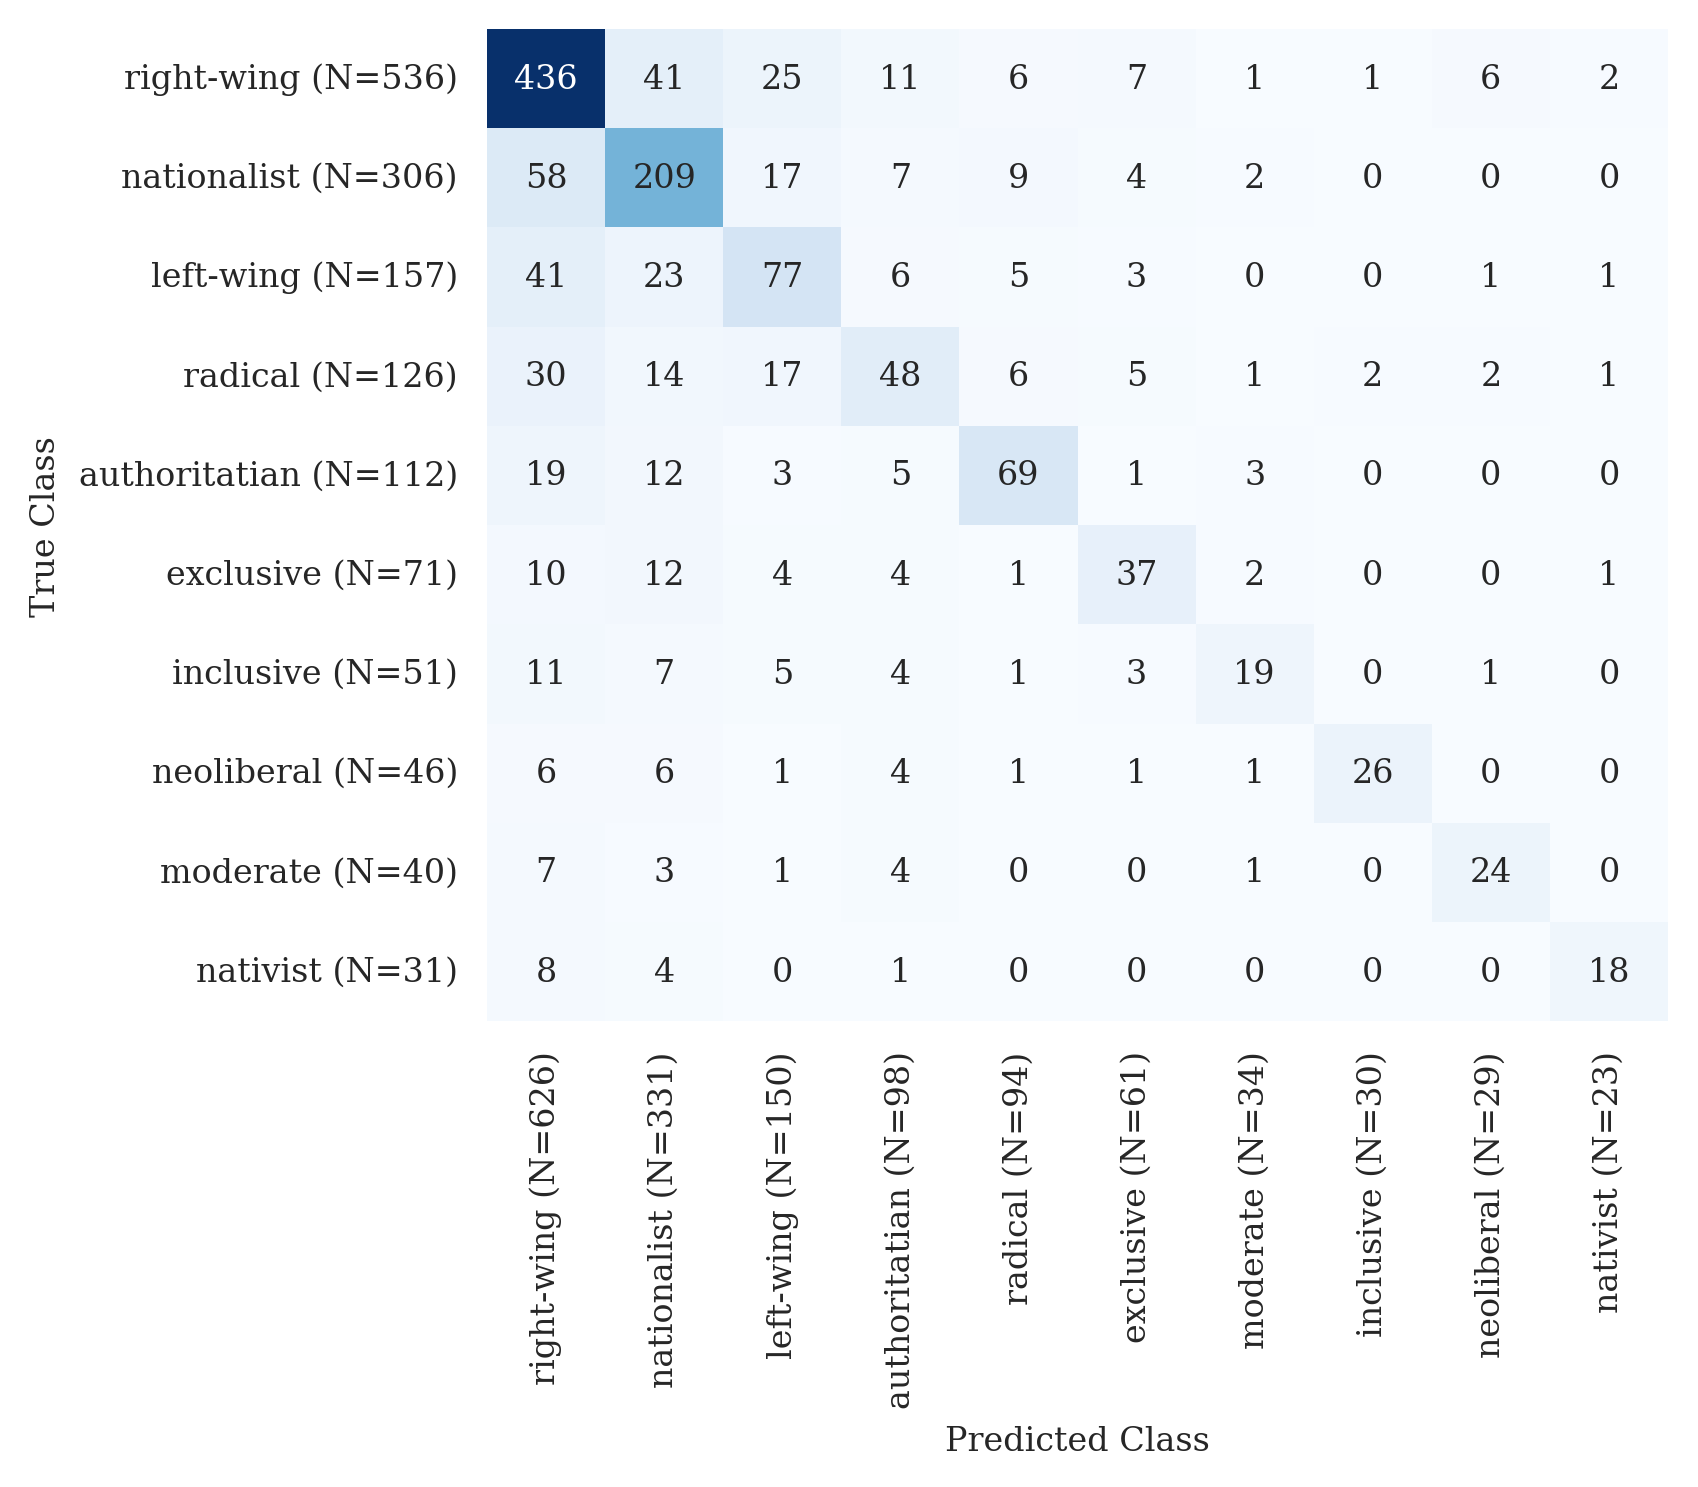

In [33]:
plt.style.use("fast")
plt.rcParams["font.family"] = "serif"
plt.rcParams['font.size'] = 8

fig, ax = plt.subplots(figsize=(5.7, 5), dpi=300, tight_layout=True)

sns.heatmap(dataframe, annot=True, cbar=None, cmap="Blues", fmt='d', ax=ax)

ax.set_ylabel("True Class")
ax.set_xlabel("Predicted Class")
plt.show()

In [34]:
dummy = DummyClassifier(strategy='stratified', random_state=1)

In [38]:
dummy.fit(X_train, y_train)
dummy.score(X_test, y_test)

0.22154471544715448

# NN based classification

## Simply neural network

In [71]:
# requires to be connected to a properly configured python environment with tensorflow etc.
import tensorflow as tf
tf.config.run_functions_eagerly(True)
from tensorflow import keras
from keras import models
from keras import layers
from keras.layers import Embedding


In [72]:
classes_inxs = dict(zip(classes, range(len(classes))))

In [73]:
def to_one_hot(y, classes):
    classes_inxs_dict = dict(zip(classes, range(len(classes))))
    results = np.zeros((len(y), len(classes)))
    for i, label in enumerate(y):
        results[i, classes_inxs_dict[label]] = 1.
    return results, classes_inxs_dict

one_hot_labels, classes_inxs_dict = to_one_hot(y, classes)

In [74]:
inxs_classes_dict = dict([(t[1], t[0]) for t in classes_inxs_dict.items()])
inxs_classes_dict

{0: 'right-wing',
 1: 'nationalist',
 2: 'left-wing',
 3: 'authoritatian',
 4: 'radical',
 5: 'exclusive',
 6: 'moderate',
 7: 'neoliberal',
 8: 'inclusive',
 9: 'nativist'}

In [75]:
one_hot_labels[:10]

array([[0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.]])

In [44]:
# TRAIN vs TEST

x_train_full, x_test, y_train_full, y_test_one_hot = train_test_split(X, one_hot_labels, test_size=0.2, random_state=1)

# actual TRAIN vs. internal VALIDATION data
x_train, x_val, y_train, y_val = train_test_split(x_train_full, y_train_full, test_size=0.2, random_state=1)

In [76]:
# since our classes are highly unbalanced w1 weighted is perhaps the best metric for model performance
def f1_weighted(y_true, y_pred):
    y_true = np.ndarray.argmax(y_true.numpy(), axis=1)
    y_pred = np.ndarray.argmax(y_pred.numpy(), axis=1)
    return f1_score(y_true, y_pred, average="weighted")

In [192]:
model = models.Sequential()
model.add(layers.Dense(1024, activation='relu', input_shape=(len(x_train[0]),)))
model.add(layers.Dense(len(classes), activation='softmax'))

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=[f1_weighted])

history = model.fit(x_train,
                    y_train,
                    epochs=10,
                    batch_size=128,
                    verbose=1,
                    validation_data=(x_val, y_val))

Epoch 1/10


/opt/homebrew/Caskroom/miniconda/base/lib/python3.9/site-packages/tensorflow/python/data/ops/structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


37/37 [==============================] - ETA: 0s - loss: 1.9676 - f1_weighted: 0.2075

/opt/homebrew/Caskroom/miniconda/base/lib/python3.9/site-packages/tensorflow/python/data/ops/structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


37/37 [==============================] - 4s 98ms/step - loss: 1.9676 - f1_weighted: 0.2075 - val_loss: 1.7352 - val_f1_weighted: 0.3005
Epoch 2/10
37/37 [==============================] - 4s 98ms/step - loss: 1.4153 - f1_weighted: 0.4407 - val_loss: 1.4593 - val_f1_weighted: 0.4464
Epoch 3/10
37/37 [==============================] - 3s 92ms/step - loss: 0.8778 - f1_weighted: 0.7001 - val_loss: 1.2551 - val_f1_weighted: 0.5622
Epoch 4/10
37/37 [==============================] - 3s 93ms/step - loss: 0.4338 - f1_weighted: 0.9063 - val_loss: 1.1764 - val_f1_weighted: 0.5996
Epoch 5/10
37/37 [==============================] - 3s 94ms/step - loss: 0.1947 - f1_weighted: 0.9790 - val_loss: 1.1742 - val_f1_weighted: 0.6275
Epoch 6/10
37/37 [==============================] - 3s 88ms/step - loss: 0.0935 - f1_weighted: 0.9974 - val_loss: 1.2127 - val_f1_weighted: 0.6279
Epoch 7/10
37/37 [==============================] - 3s 93ms/step - loss: 0.0528 - f1_weighted: 0.9996 - val_loss: 1.2451 - val_f1

/opt/homebrew/Caskroom/miniconda/base/lib/python3.9/site-packages/tensorflow/python/data/ops/structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


47/47 [==============================] - 3s 62ms/step - loss: 1.2960 - f1_weighted: 0.6288


In [194]:
results = model.evaluate(x_test, y_test_one_hot)
results

 2/47 [>.............................] - ETA: 2s - loss: 0.9033 - f1_weighted: 0.7048

/opt/homebrew/Caskroom/miniconda/base/lib/python3.9/site-packages/tensorflow/python/data/ops/structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


47/47 [==============================] - 3s 62ms/step - loss: 1.2960 - f1_weighted: 0.6288


[1.2959922552108765, 0.6288107633590698]

In [197]:
y_predicted_one_hot = model.predict(x_test)
y_predicted = [inxs_classes_dict[i] for i in np.argmax(y_predicted_one_hot, axis=1)]

47/47 [==============================] - 0s 5ms/step


In [198]:
f1_score(y_predicted, y_test, average="weighted")

0.6548739390014741

In [246]:
inxs_classes_dict

{0: 'right-wing',
 1: 'nationalist',
 2: 'left-wing',
 3: 'authoritatian',
 4: 'radical',
 5: 'exclusive',
 6: 'moderate',
 7: 'neoliberal',
 8: 'inclusive',
 9: 'nativist'}

In [249]:
pd.DataFrame(y_predicted_one_hot[:10].round(2), columns=labels)

,right-wing,nationalist,left-wing,authoritatian,radical,exclusive,moderate,neoliberal,inclusive,nativist
0,0.01,0.01,0.00,0.00,0.97,0.01,0.00,0.00,0.00,0.00
1,0.01,0.80,0.02,0.01,0.11,0.00,0.00,0.04,0.00,0.00
2,0.26,0.02,0.71,0.01,0.00,0.00,0.00,0.00,0.00,0.00
3,0.00,0.00,0.02,0.00,0.02,0.00,0.96,0.00,0.00,0.00
4,0.00,0.99,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
5,0.98,0.00,0.00,0.00,0.00,0.01,0.00,0.00,0.00,0.00
6,0.06,0.91,0.01,0.00,0.00,0.00,0.00,0.01,0.00,0.00
7,0.04,0.84,0.02,0.02,0.02,0.00,0.04,0.00,0.01,0.01
8,0.01,0.94,0.00,0.02,0.00,0.00,0.01,0.01,0.00,0.00
9,0.00,0.95,0.00,0.04,0.00,0.00,0.00,0.00,0.00,0.00


In [255]:
len(np.max(y_predicted_one_hot, axis=1))

1476

In [259]:
sum(np.max(y_predicted_one_hot, axis=1) > 0.75)

917

# Neural networks with embeddings

In [15]:
vocab = [tup[0] for tup in vocab_counts]

In [16]:
w2v = KeyedVectors.load("../data/large_data/w2v_news300.model")
w2v.most_similar("extremism")

[('religious_extremism', 0.8095038533210754),
 ('radicalism', 0.7823387980461121),
 ('violent_extremism', 0.7761071920394897),
 ('Islamic_extremism', 0.7622053027153015),
 ('Islamic_fundamentalism', 0.7453163266181946),
 ('Islamic_radicalism', 0.7362303137779236),
 ('militancy', 0.7344785928726196),
 ('radical_Islam', 0.7271879315376282),
 ('Islamist_extremism', 0.7208510041236877),
 ('extremists', 0.7103613615036011)]

In [17]:
w2v_filtered = KeyedVectors(vector_size=300)
vocab_filtered = []
# Iterate over the original KeyedVectors object
for word in vocab:
    try:
        w2v_filtered[word] = w2v[word]
        vocab_filtered.append(word)
    except:
        pass

In [19]:
w2v_filtered.vectors[0]

array([ 3.78906250e-01,  5.02929688e-02, -3.19824219e-02,  4.02343750e-01,
       -8.93554688e-02, -1.26953125e-01,  3.07617188e-02,  1.50390625e-01,
        6.88476562e-02, -1.47460938e-01, -6.68945312e-02, -9.86328125e-02,
        9.61914062e-02,  4.45312500e-01, -2.85644531e-02,  5.34667969e-02,
       -1.27563477e-02,  3.41796875e-01,  1.18652344e-01, -1.09863281e-01,
        2.12890625e-01,  2.34375000e-01,  2.63671875e-01,  2.27539062e-01,
        5.24902344e-02, -1.16210938e-01, -9.47265625e-02, -1.27929688e-01,
        5.00000000e-01,  2.00195312e-01, -1.87500000e-01,  1.78710938e-01,
        5.03540039e-03,  1.04492188e-01,  2.73437500e-01, -1.90429688e-01,
        5.46875000e-02, -1.74804688e-01,  3.90625000e-02,  6.49414062e-02,
        3.57421875e-01, -2.37304688e-01,  3.94531250e-01, -2.31933594e-02,
       -1.24023438e-01, -4.12597656e-02, -7.56835938e-02,  5.63964844e-02,
        4.62890625e-01, -1.08398438e-01, -1.06933594e-01, -4.58984375e-02,
       -6.83593750e-02, -

In [134]:
max([len(conc) for conc in concs])

20

In [135]:
vectorizer = TextVectorization(
    standardize=None,
    output_mode="int",
    output_sequence_length=20
    #vocabulary=vocab
)

In [136]:
vectorizer.adapt([" ".join(conc) for conc in concs])

/opt/homebrew/Caskroom/miniconda/base/lib/python3.9/site-packages/tensorflow/python/data/ops/structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


In [137]:
#  index 0 is reserved for padding and index 1 is reserved for "out of vocabulary" tokens
vectorizer([["be stupid populist"]])

<tf.Tensor: shape=(1, 20), dtype=int64, numpy=
array([[2967,    1,    2,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0]])>

In [138]:
voc = vectorizer.get_vocabulary()
word_index = dict(zip(voc, range(len(voc))))

In [139]:
voc[:5]

['', '[UNK]', 'populist', 'populism', 'party']

In [140]:
num_tokens = len(voc) + 2
embedding_dim = w2v_filtered.vectors.shape[1]
embedding_matrix = np.zeros((num_tokens, 300))
for word, i in word_index.items():
    try:
        # Words not found in embedding index will be all-zeros.
        # This includes the representation for "padding" and "OOV"
        embedding_matrix[i] = vector = w2v[word]
    except:
        pass

In [141]:
embedding_layer = Embedding(
    num_tokens,
    embedding_dim,
    embeddings_initializer=keras.initializers.Constant(embedding_matrix),
    trainable=False,
)

In [142]:
sequences = vectorizer([" ".join(conc) for conc in concs]).numpy()
sequences[:20]

array([[ 1694,    37,   919,  1055,    56,  1350,   573,     5,   870,
            2,   194,   133,   678,  7081,  5006,   645,   426,    72,
          517, 10304],
       [ 6596,  1309,  4712,  1584,  1048,    36,  5448,   538,   118,
           12,     2,   582,  3968,    94,   142,  1370,     7,  4504,
          956,    84],
       [  118,  1305,     3,   167,   389,   236,   745,   102,   157,
         1654,     2,    10,   687,  2607,  2592,  3722,  6241,  8597,
          517,    12],
       [ 1140,   492,   913,   261,  6663,   499,  2319,  2757,  1133,
           91,     2,  1140,  6493,    21,    84,   461,  1447,   664,
          206,    27],
       [ 2227,   727,  4166,   203,    75,  1599,  2985,  1874,    63,
          103,     2,    10,  1778,     9,   195,  2009,   175,  2027,
           25,  2951],
       [    9,   195,  2009,   175,  2027,    25,  2951,   206,  1151,
            2,  2607,   687,     7,  2339,    49,   637,  2574,     2,
         8382,     7],
       [  

In [163]:
int_sequences_input = keras.Input(shape=(None,), dtype="int64")
embedded_sequences = embedding_layer(int_sequences_input)
x = layers.Conv1D(512, 5, activation="relu")(embedded_sequences)
#x = layers.MaxPooling1D(5)(x)
#x = layers.Conv1D(128, 5, activation="relu")(x)
#x = layers.MaxPooling1D(5)(x)
#x = layers.Conv1D(128, 5, activation="relu")(x)
x = layers.GlobalMaxPooling1D()(x)
x = layers.Dense(256, activation="relu")(x)
x = layers.Dense(128, activation="relu")(x)
x = layers.Dropout(0.5)(x)
preds = layers.Dense(len(classes), activation='softmax')(x)
model = keras.Model(int_sequences_input, preds)
model.summary()

Model: "model_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_19 (InputLayer)       [(None, None)]            0         
                                                                 
 embedding_2 (Embedding)     (None, None, 300)         4042200   
                                                                 
 conv1d_25 (Conv1D)          (None, None, 512)         768512    
                                                                 
 global_max_pooling1d_16 (Gl  (None, 512)              0         
 obalMaxPooling1D)                                               
                                                                 
 dense_37 (Dense)            (None, 256)               131328    
                                                                 
 dense_38 (Dense)            (None, 128)               32896     
                                                          

In [164]:
# TRAIN vs TEST

x_train_full, x_test, y_train_full, y_test_one_hot = train_test_split(sequences, one_hot_labels, test_size=0.2, random_state=1)

# actual TRAIN vs. internal VALIDATION data
x_train, x_val, y_train, y_val = train_test_split(x_train_full, y_train_full, test_size=0.2, random_state=1)

In [165]:
model.compile(
    loss="categorical_crossentropy", optimizer="adam", metrics=[f1_weighted]
)
model.fit(x_train, y_train, batch_size=64, epochs=10, validation_data=(x_val, y_val))

Epoch 1/10


/opt/homebrew/Caskroom/miniconda/base/lib/python3.9/site-packages/tensorflow/python/data/ops/structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


74/74 [==============================] - ETA: 0s - loss: 1.9040 - f1_weighted: 0.2481

/opt/homebrew/Caskroom/miniconda/base/lib/python3.9/site-packages/tensorflow/python/data/ops/structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


74/74 [==============================] - 7s 93ms/step - loss: 1.9040 - f1_weighted: 0.2481 - val_loss: 1.7933 - val_f1_weighted: 0.2177
Epoch 2/10
74/74 [==============================] - 7s 91ms/step - loss: 1.6145 - f1_weighted: 0.3801 - val_loss: 1.5688 - val_f1_weighted: 0.4101
Epoch 3/10
74/74 [==============================] - 7s 89ms/step - loss: 1.0555 - f1_weighted: 0.5993 - val_loss: 1.4712 - val_f1_weighted: 0.4837
Epoch 4/10
74/74 [==============================] - 7s 89ms/step - loss: 0.5099 - f1_weighted: 0.8199 - val_loss: 1.5990 - val_f1_weighted: 0.5279
Epoch 5/10
74/74 [==============================] - 6s 87ms/step - loss: 0.2150 - f1_weighted: 0.9384 - val_loss: 2.0242 - val_f1_weighted: 0.4941
Epoch 6/10
74/74 [==============================] - 6s 88ms/step - loss: 0.0868 - f1_weighted: 0.9815 - val_loss: 1.7980 - val_f1_weighted: 0.5629
Epoch 7/10
74/74 [==============================] - 6s 85ms/step - loss: 0.0494 - f1_weighted: 0.9906 - val_loss: 1.9888 - val_f1

In [166]:
results = model.evaluate(x_test, y_test_one_hot)
results

 2/47 [>.............................] - ETA: 2s - loss: 1.4146 - f1_weighted: 0.6781

/opt/homebrew/Caskroom/miniconda/base/lib/python3.9/site-packages/tensorflow/python/data/ops/structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


47/47 [==============================] - 3s 57ms/step - loss: 2.0383 - f1_weighted: 0.5782


[2.0383424758911133, 0.5782015919685364]

In [167]:
y_predicted_one_hot = model.predict(x_test)
y_predicted = [inxs_classes_dict[i] for i in np.argmax(y_predicted_one_hot, axis=1)]

f1_score(y_predicted, y_test, average="weighted")

24/47 [==============>...............] - ETA: 0s

/opt/homebrew/Caskroom/miniconda/base/lib/python3.9/site-packages/tensorflow/python/data/ops/structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


47/47 [==============================] - 0s 7ms/step


0.6250736879356592